# Explore energy

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
# Specify the dataset by date
DAYLIO_DATE = '11_20'

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Read 

In [2]:
# Read CSV file exported from the Daylio app
filename = f'transformed_data_{DAYLIO_DATE}.csv'
df = pd.read_csv(filename)
df.set_index('datetime', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44 entries, 2023-10-07 23:59:00 to 2023-11-20 03:38:00
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   success                        44 non-null     float64
 1   energy                         44 non-null     float64
 2   sleep                          44 non-null     float64
 3   caffeine                       44 non-null     float64
 4   job_hours                      44 non-null     float64
 5   study_hours                    44 non-null     float64
 6   total_work_hours               44 non-null     float64
 7   luck                           44 non-null     float64
 8   strategy                       44 non-null     float64
 9   agreeableness                  44 non-null     float64
 10  takeaway                       44 non-null     int64  
 11  board games                    44 non-null     int64  
 12  youtube               

### Dynamics of Energy and Success
* Energy is linked to success

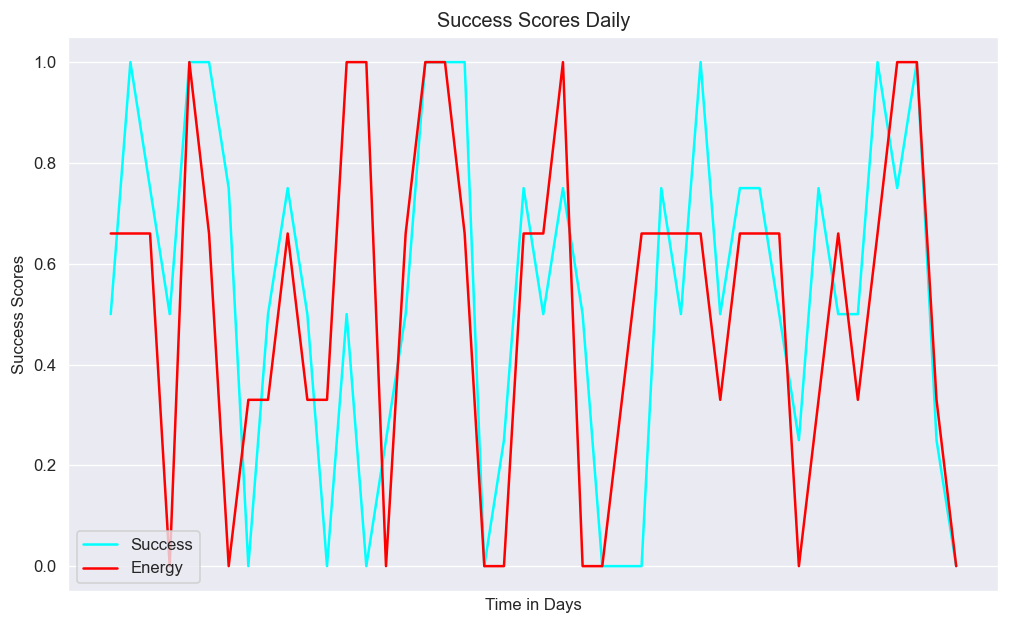

In [3]:
plt.figure(figsize=(10, 6), dpi=120)
plt.plot(df.index, df['success'], label='Success', color='cyan')
plt.plot(df.index, df['energy'], label='Energy', color='red')
plt.title('Success Scores Daily')
plt.xlabel('Time in Days')
plt.ylabel('Success Scores')
plt.xticks([])
plt.legend()
plt.show()

### Calculate average effect on energy

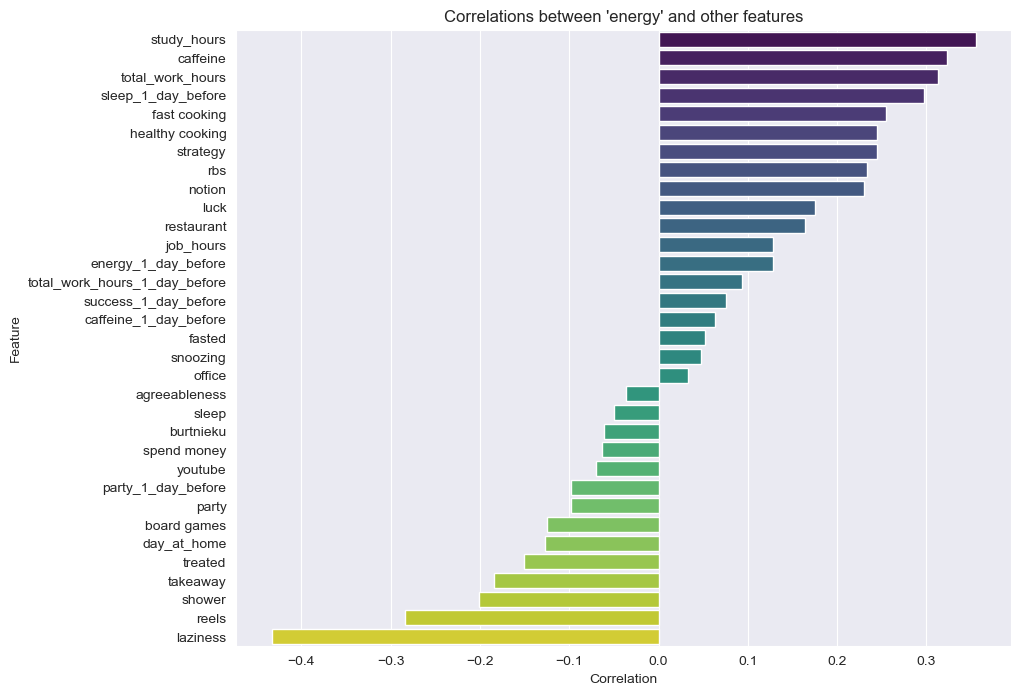

In [4]:
# Select only the numeric columns (excluding 'datetime')
numeric_columns = df.iloc[:, 2:].select_dtypes(include=['float64', 'int64'])
# Calculate the correlation matrix
correlation_matrix = numeric_columns.corrwith(df['energy'])
# Create a DataFrame with correlations
correlation_df = correlation_matrix.reset_index()
correlation_df.columns = ['Feature', 'Correlation']
correlation_df.sort_values(by='Correlation', ascending=False, inplace=True)
# Create a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(data=correlation_df, x='Correlation', y='Feature', palette="viridis")
# Set the height of the bars
bar_height = 0.5  # Adjust as needed
# Customize the plot
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.title("Correlations between 'energy' and other features")
# Adjust the y-axis labels and set the bar height
plt.yticks(range(len(correlation_df['Feature'])), correlation_df['Feature'], fontsize=10)
# Show the plot
plt.show()

### Remove features that obviously have effect on energy


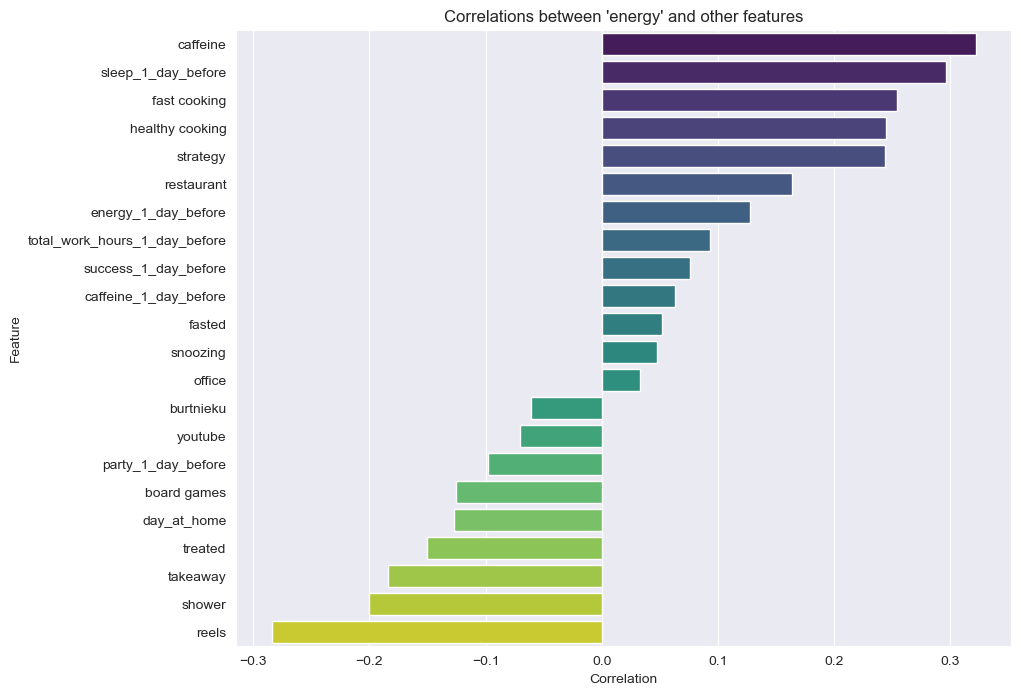

In [5]:
non_energy_cols = [
    'luck',
    'agreeableness',
    'success',  # Energy defines success for a day but not vice verca
    'rbs',
    'github',
    'spend money',
    'notion',
    'overspending',
    'party',
    'movie',
    'total_work_hours',
    'job_hours',
    'study_hours',
    'priezu veji',
    'laziness'
]
df.drop(columns=non_energy_cols, inplace=True, errors='ignore')
# Select only the numeric columns (excluding 'datetime')
numeric_columns = df.iloc[:, 2:].select_dtypes(include=['float64', 'int64'])
# Calculate the correlation matrix
correlation_matrix = numeric_columns.corrwith(df['energy'])
# Create a DataFrame with correlations
correlation_df = correlation_matrix.reset_index()
correlation_df.columns = ['Feature', 'Correlation']
correlation_df.sort_values(by='Correlation', ascending=False, inplace=True)
# Create a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(data=correlation_df, x='Correlation', y='Feature', palette="viridis")
# Set the height of the bars
bar_height = 0.5  # Adjust as needed
# Customize the plot
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.title("Correlations between 'energy' and other features")
# Adjust the y-axis labels and set the bar height
plt.yticks(range(len(correlation_df['Feature'])), correlation_df['Feature'], fontsize=10)
# Show the plot
plt.show()

### XGBoost Predictability

In [6]:
X = df.iloc[:, 2:].copy()
y = df.iloc[:, 0].copy()
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
# Creating an XGBoost model
model = xgb.XGBRegressor(n_estimators=80, max_depth=4, eta=0.02)
model.fit(X_train, y_train)
# Assuming 'model' is your trained XGBoost regressor
y_pred = model.predict(X_test)  # Predicting the continuous values for the test set
# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
# Display the mean squared error
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.1901290463177469


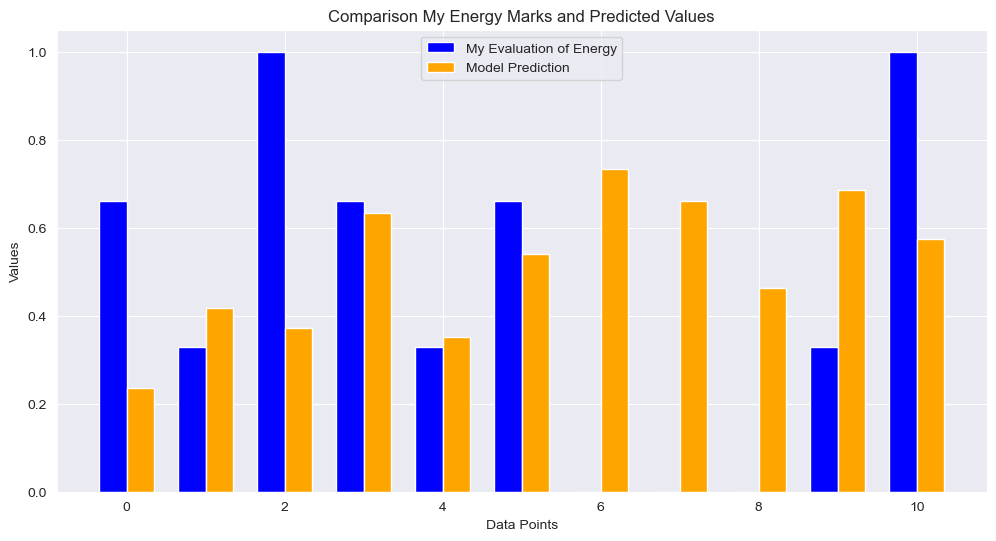

In [7]:
indices = np.arange(len(y_test))
bar_width = 0.35
plt.figure(figsize=(12, 6))
plt.bar(indices - bar_width/2, y_test, bar_width, label='My Evaluation of Energy', color='blue')
plt.bar(indices + bar_width/2, y_pred, bar_width, label='Model Prediction', color='orange')
plt.xlabel('Data Points')
plt.ylabel('Values')
plt.title('Comparison My Energy Marks and Predicted Values')
plt.legend()
plt.show()

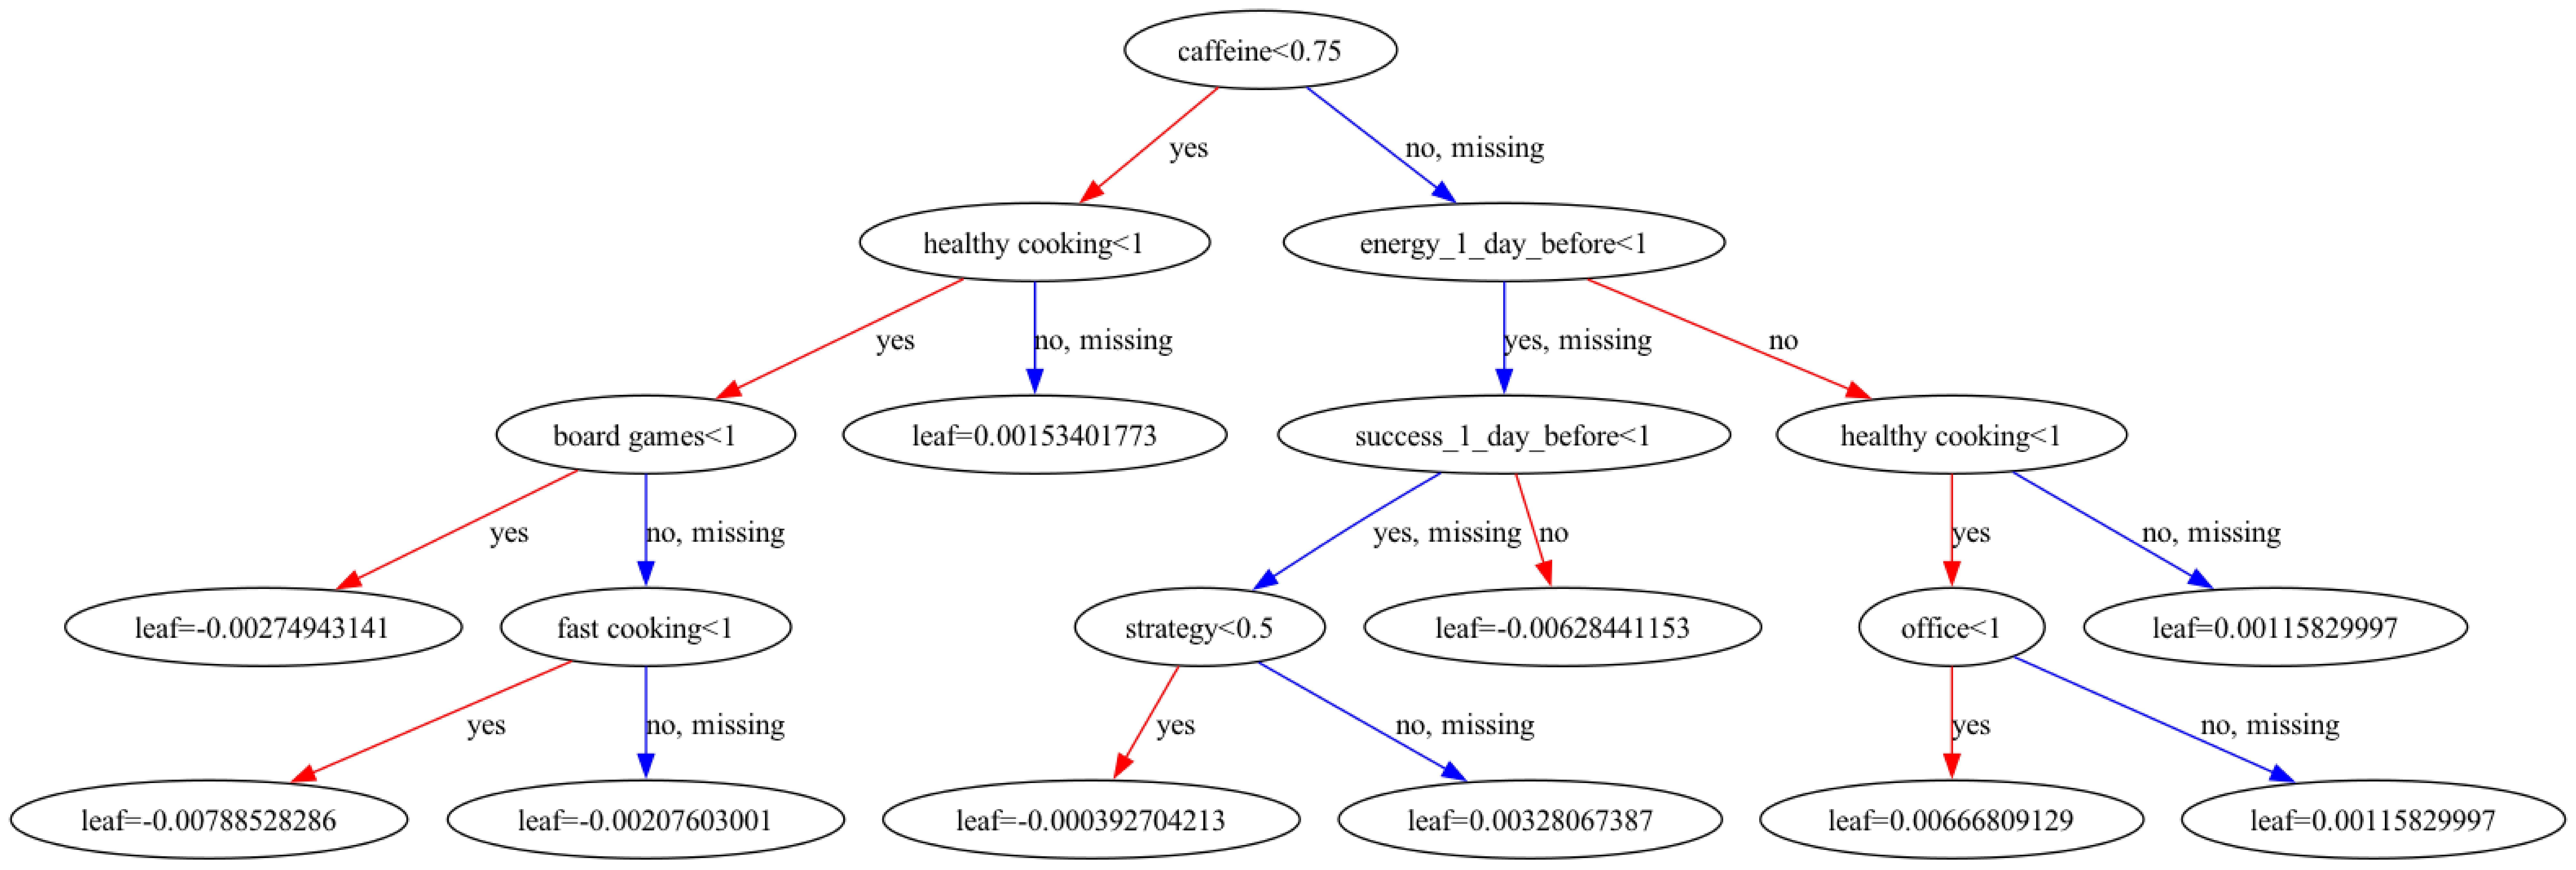

In [8]:
# Plotting one of the decision trees
xgb.plot_tree(model, num_trees=2)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

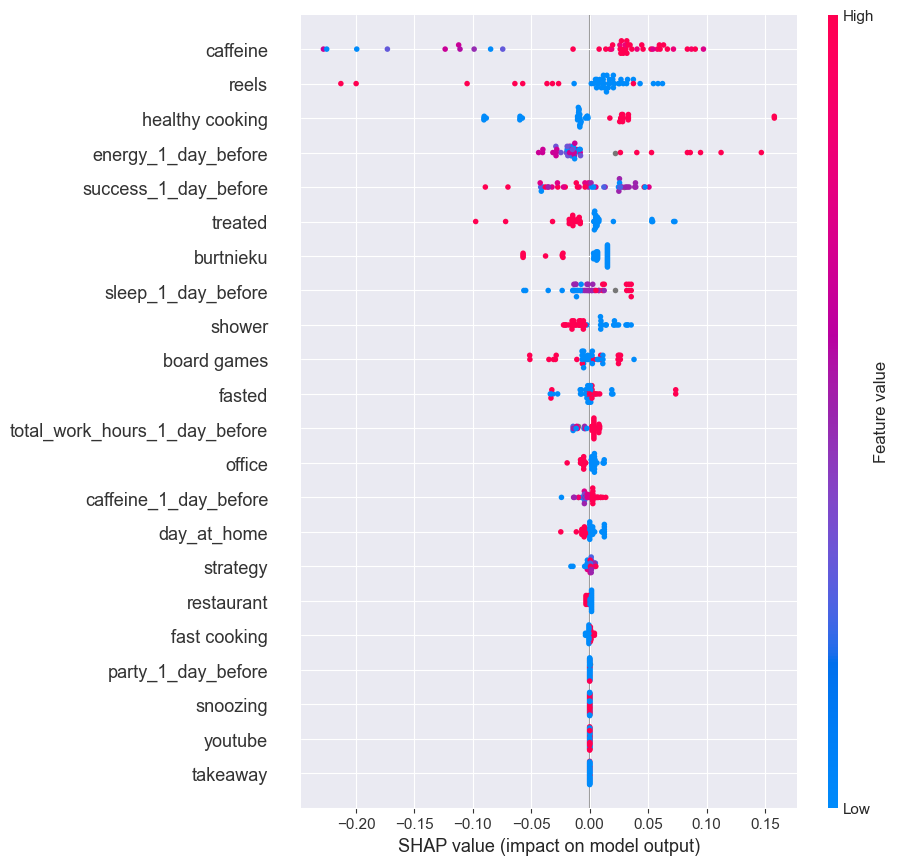

In [9]:
model = xgb.XGBRegressor(n_estimators=80, max_depth=4, eta=0.02)
model.fit(X, y)
y_pred = model.predict(X)
# Explain the model's predictions using SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.beeswarm(shap_values, max_display=30)

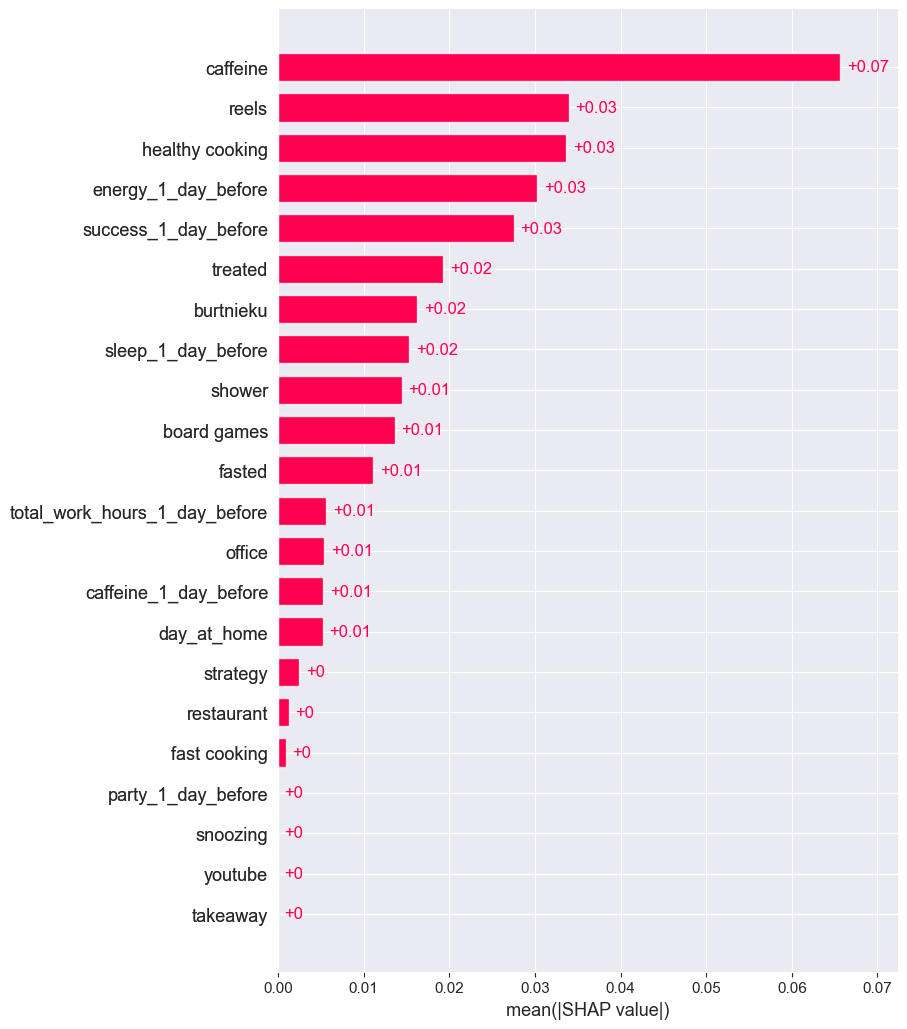

In [10]:
shap.plots.bar(shap_values.abs.mean(0), max_display=30)

### Summary

*  